
# PID Synthesis for a discrete second order system

In [1]:
%matplotlib widget
import numpy as np
from IPython.display import display, Math, Latex
from sympy import symbols, fraction, simplify, latex, collect, expand, exp, solve, cos

Let's consider a PID controler with the continuous form 
$$ C(s) = K_p + \frac{1}{T_i s} + \frac{T_d s}{1 + \tau s}, $$
with $K_p$ the proportional gain, $T_i$ the integral gain, $T_d$ the proportional gain, $\tau$ the filter time constant for the derivative part and $s$ the Laplace transform.

In [2]:
# PID SYNTHESIS
s, z = symbols('x z') # laplace and z variable
te = symbols('T_e') # sampling time
Kp, Ti, Td, tau = symbols(' K_p T_i T_d tau') # PID parameters, tau is the filter for the derivative part
C = ( Kp + 1/Ti/s + Td*s/(1 + tau*s) )

Let's discretise the PID using the bilinear form:
$$ p \leftarrow \frac{2}{T_e} \frac{z - 1}{z + 1}, $$
with $T_e$ the sampling time, and $z$ the Z variable.

In [3]:
# bilinear discretisation
C_d = C.subs([(s, 2/te * (z - 1)/(z+1))]).together()
print("PID bilinear discretisation at Te sampling time, C(z): ")
display(Math(latex(C_d))) # print C_d in a more readable form

PID bilinear discretisation at Te sampling time, C(z): 


<IPython.core.display.Math object>

Now, if we consider a second order model, discretized with a zero order hold, we have a discrete transfer function of the form:
$$ H(z) = \frac{a_1 z + a_0}{z^2 + b_1 z + b_0} $$

In [4]:
a0, a1, b0, b1, b2 = symbols('a_0 a_1 b_0 b_1 b_2') # PID parameters
H_d = ( a1*z + a0 ) / ( z**2 + b1*z + b0 ) # symbolic form of sysd

The open loop of the PID and system model can be obtained by multiplying them. If there is no transfer on the return, then the closed loop of the PID and the system can be written:
$$ CL(z) = \frac{C(z) H(z)}{1 + C(z) H(z)} $$

In [5]:
CL = simplify( C_d*H_d/(1 + C_d*H_d) ) # close loop transfer function
OL = simplify( C_d*H_d ) # open loop transfer function
print("Open loop C_d(z) H_d(z):")
display(Math(latex(OL)))

Open loop C_d(z) H_d(z):


<IPython.core.display.Math object>

We want to chose the PID parameters so that the open loop transfer can be written:
$$ C_{des}(z)H(z) = \frac{a_1 z + a_0}{2 T_{i} \left(z - 1\right) \left(T_{e} \left(z + 1\right) + 2 \tau \left(z - 1\right)\right)} $$
Therefore, the PID parameters needs to be tuned to compensate the denominator of the transfer function. When looking at the open loop transfer function we can write the following equation:
$$4 T_{d} T_{i} \left(z - 1\right)^{2} + T_{e} \left(z + 1\right) \left(T_{e} \left(z + 1\right) + 2 \tau \left(z - 1\right)\right) + 2 T_{i} \left(z - 1\right) \left(T_{e} \left(z + 1\right) + 2 \tau \left(z - 1\right)\right) = b_0 + b_1 z + z^2$$

In [6]:
C_d_num, C_d_den = fraction(C_d) # extracting the numerator of the open loop
poly_1 = collect(expand(C_d_num), z)
display(Math(latex(poly_1) + " = b_0 + b_1 z + z^2"))

<IPython.core.display.Math object>

For this equality to be solvable, the coefficient in front of $z^2$ needs to be taken off. The all open loop representation therefore need to be represented by dividing both part of the fraction by this coefficient $G$:
$$ G = \left(4 K_{p} T_{d} T_{i} + K_{p} T_{e}^{2} + 2 K_{p} T_{e} T_{i} + 2 K_{p} T_{e} \tau + 4 K_{p} T_{i} \tau\right) $$
Then the open loop transfer will look like:
$$ C_{des}(z)H(z) = G \frac{a_1 z + a_0}{2 T_{i} \left(z - 1\right) \left(T_{e} \left(z + 1\right) + 2 \tau \left(z - 1\right)\right)} $$

In [7]:
coeff_b2 = poly_1.coeff(z, 2)# /poly_1.coeff(z, 2)
coeff_b1 = poly_1.coeff(z, 1) / coeff_b2
coeff_b0 = poly_1.coeff(z, 0) / coeff_b2
gain = 1/coeff_b2
display(Math("b_0 =" + latex(coeff_b0)))
display(Math("b_1 =" + latex(coeff_b1)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We now have two equations with 4 unknowns. These first equations help to compensate the dynamic behaviour of the system. Now we will force the system to behave as a second order system with a desired dynamic behaviour. It will provide us the missing two equations.
Let's consider a second order system of the form:
$$ \frac{\omega_0^2}{s^2 + 2\xi\omega_0 s + \omega_0^2} $$
The pulsation $\omega_0$ and the damping $\xi$ define the system response time and overshoot.
Let's say we want a system with 20% overshoot and 120 seconds response time, that gives us:
$$ \xi = 0.45 $$
$$ \omega_0 = 0.025 \text{ rad.s}^{-1} $$
Let's call $\lambda_1$ and $\lambda_2$ the roots of the denominator (the poles of the system).

In [8]:
xi = 0.45
w0 = 0.025
a = 1
b = 2*xi*w0
c = w0**2
delta = b**2 - 4*a*c
if delta < 0:
    l1 = ( -b - np.sqrt(b**2 - 4*a*c + 0j) )/(2*a)
    l2 = ( -b + np.sqrt(b**2 - 4*a*c + 0j) )/(2*a)
elif delta > 0:
    l1 = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    l2 = (-b + np.sqrt(b**2 - 4*a*c))/(2*a)

The pole found, can be discretized with the following formula:
$$ z_1 = e^{\lambda_1 T_e} $$
To impose the dynamic of these poles to our system, we need to make them appear at the denominator of the close loop system, that is:

$$ \frac{C(z)H(z)}{1+C(z)H(z)} = G \frac{a_1 z + a_0}{a_1 z + a_0 + 2 T_{i} \left(z - 1\right) \left(T_{e} \left(z + 1\right) + 2 \tau \left(z - 1\right)\right)} $$

$$(z - z_1)(z-z_2) = a_1 z + a_0 + 2 T_{i} \left(z - 1\right) \left(T_{e} \left(z + 1\right) + 2 \tau \left(z - 1\right)\right) $$

In [9]:
CL_den = collect(expand(C_d_den + a1*z + a0), z)
desired_den = collect(expand( (z - exp(l1*te))*( z - exp(l2*te) ) ), z)
display(Math(latex(CL_den)))

<IPython.core.display.Math object>

Once again, we need to take off the coefficient in front of $z^2$, now:
$$ G = \frac{\left(4 K_{p} T_{d} T_{i} + K_{p} T_{e}^{2} + 2 K_{p} T_{e} T_{i} + 2 K_{p} T_{e} \tau + 4 K_{p} T_{i} \tau\right)}{2 T_{e} T_{i} + 4 T_{i} \tau} $$

In [10]:
gain = gain*CL_den.coeff(z, 2)
coeff_den2 = CL_den.coeff(z, 2)
coeff_den1 = CL_den.coeff(z, 1)/coeff_den2
coeff_den0 = CL_den.coeff(z, 0)/coeff_den2

We now have 4 equations and 4 unknows to obtain a close loop of the following form:
$$ \frac{C(z)H(z)}{1+C(z)H(z)} = G \frac{a_1 z + a_0}{(z - z_1) (z - z_2)}, $$
with $G$ the gains that were taken off the z coefficients.

In [12]:
eq1 = coeff_b0 - b0
eq2 = coeff_b1 - b1
eq3 = coeff_den0 - desired_den.coeff(z,0) 
eq4 = coeff_den1 - desired_den.coeff(z,1).rewrite(cos).simplify() # to avoid having complex exponentials
# to solve this system of equation, we need to substitute the parameters of the studied system a0, a1, b0 and b1.

Let's consider the following system:
$$ H(z) =  \frac{0.008373 z + 0.001522}{z^2 - 1.622 z + 0.6322}\quad dt = 1.0$$

**<span style="color:red"> /!\ The method proposed here cannot work with this system, that has an unstable pole (|p| > 1). It will work in simulation thanks to the perfect compensation of the unstable pole, but in reality, since the compensation will not be perfect, it will just add instability.</span>**

In [13]:
b0_t = -1.6221898676716258
b1_t = 0.6322237854789634
a0_t = 0.008373147756958077
a1_t = 0.0015218514893243773
dt = 1
leq = []
for eq in [eq1, eq2, eq3, eq4]:
    leq.append(eq.subs([(b0, b0_t), (b1, b1_t), (a0, a0_t), (a1, a1_t), (te, dt)]))
    # print(leq[-1].free_symbols)

In [30]:
sol = solve(leq, (Kp, Ti, Td, tau))

In [15]:
display(Math(latex(eq1))) 
display(Math(latex(eq2))) 
display(Math(latex(eq3))) 
display(Math(latex(eq4))) 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [37]:
num_sol = []
for sol_i in sol[0]:
    num_sol.append(float(sol_i))

Solving the system of equations with scipy optimize and fsolve:

In [52]:
print("Kp = {}".format(num_sol[0]))
print("Ti = {}".format(num_sol[1]))
print("Td = {}".format(num_sol[2]))
print("tau = {}".format(num_sol[3]))
C_d = C_d.subs([(Kp,num_sol[0]), (Ti,num_sol[1]), (Td,num_sol[2]), (tau,num_sol[3]), (te,dt)])
H_d = H_d.subs([(b0, b0_t), (b1, b1_t), (a0, a0_t), (a1, a1_t), (te, dt)])

Kp = 2390.690945686486
Ti = 0.0911529185419961
Td = -104132.68581107013
tau = 43.41414684510419


In [61]:
CL_t = simplify(CL.subs([(b0, b0_t), (b1, b1_t), (a0, a0_t), (a1, a1_t), (Kp,num_sol[0]), (Ti,num_sol[1]), (Td,num_sol[2]), (tau,num_sol[3]), (te,dt)]))

Now that we have the closed loop of the corrected system, let's simulate its behaviour and compare it to the desired behaviour.

In [62]:
import control as ctrl
from control.matlab import step
import matplotlib.pyplot as plt
from ipywidgets import *
from sympy import Poly
# from sympy.physics.control.lti import TransferFunction

In [63]:
num_cl_t, den_cl_t = fraction(CL_t)
num_coeff = []
den_coeff = []
n_num = Poly(num_cl_t, z).degree()
n_den = Poly(den_cl_t, z).degree()
for n in range(n_num+1):
    num_coeff.insert(0, float(num_cl_t.coeff(z,n)))
for n in range(n_den+1):
    den_coeff.insert(0, float(den_cl_t.coeff(z,n)))
num_coeff = np.array(num_coeff)
den_coeff = np.array(den_coeff)

In [64]:
# cl_tf = TransferFunction(num_cl_t, den_cl_t, z)
# sysd = ctrl.TransferFunction([620781348.627607, 3016513257.36736, -2390433148.76705, -1073936125.39993], [2177.00836206639, 620778196.370665, 3016509214.35439, -2390424315.75562, -1073939940.14981], dt)
sysd = ctrl.TransferFunction(num_coeff, den_coeff, dt)

Text(0.5, 1.0, 'Unit step response')

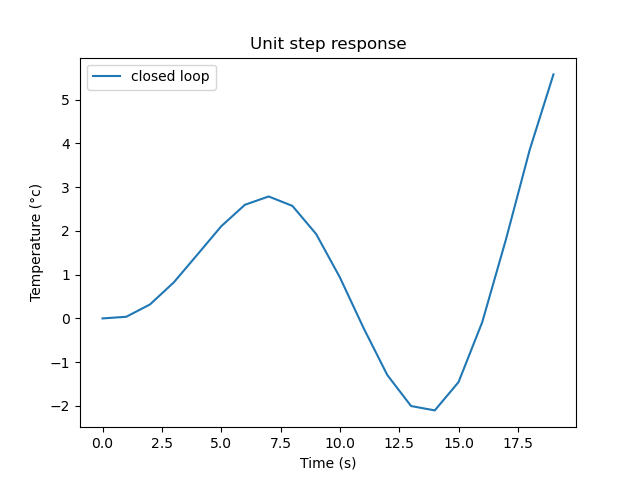

In [66]:
t, y = ctrl.step_response(sysd)
fig, ax = plt.subplots()
labels = []
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)')
ax.plot(t, y, color="tab:blue", label='closed loop')
ax.legend()
ax.set_title("Unit step response")
# fig.tight_layout()